<a href="https://colab.research.google.com/github/dpant/TensorFlow/blob/main/TweetsSentiments-GloveEmbedding300d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import nltk
nltk.download('book')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
import sklearn

import codecs
from tqdm import tqdm

[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/chat80.zip.
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package conll2000 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/conll2000.zip.
[nltk_data]    | Downloading package conll2002 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/conll2002.zip.
[nltk_data]    | Downloading package dependency_treebank to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/dependency_treebank.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    

In [3]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv



--2021-07-15 22:20:14--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  62.8MB/s    in 3.6s    

2021-07-15 22:20:18 (62.8 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [4]:
raw = pd.read_csv('/tmp/training_cleaned.csv', header=None)

In [5]:
raw.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Sampling raw dataset

In [6]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n))
    df_.index = df_.index.droplevel(0)
    return df_

In [7]:
df = stratified_sample_df(raw, 0, 100000).reset_index(drop=True)
df

,0,1,2,3,4,5
0,0,2257030907,Sat Jun 20 13:41:08 PDT 2009,NO_QUERY,jan1e93,@FaridahF 3 DAYS!!!thats too long i have to b...
1,0,1990112038,Mon Jun 01 03:55:10 PDT 2009,NO_QUERY,layamaria,confesses that she doesn't know how to cook h...
2,0,1974924097,Sat May 30 14:05:14 PDT 2009,NO_QUERY,jonas_lover24,i am sooo nervous today..uhh i just wanna go h...
3,0,1977783101,Sat May 30 21:42:02 PDT 2009,NO_QUERY,NCStoked,Saying goodnight is the hardest part..
4,0,2215424082,Wed Jun 17 18:07:16 PDT 2009,NO_QUERY,pitbull808,Shopping with a GF... All I can think..there g...
...,...,...,...,...,...,...
199995,4,1990279187,Mon Jun 01 04:25:18 PDT 2009,NO_QUERY,lavapiez,@DavidArchie but i did watch all of your guest...
199996,4,1933060035,Tue May 26 22:53:38 PDT 2009,NO_QUERY,sorchamorrigan,@PegasusAngel @dannysgirlsg1 &quot;Good mornin...
199997,4,2055743560,Sat Jun 06 09:52:34 PDT 2009,NO_QUERY,iluvjbs,going away on holiday
199998,4,1997030058,Mon Jun 01 16:07:38 PDT 2009,NO_QUERY,Stassi09,@MizzSexiiBaby thx for the twesent bestie!!!


## Cleaning dataset

In [8]:
df.rename(columns = {0:'target', 5:'text'}, inplace = True)

In [9]:
df = df.drop([1, 2, 3, 4], axis=1)

In [10]:
df.head()

,target,text
0,0,@FaridahF 3 DAYS!!!thats too long i have to b...
1,0,confesses that she doesn't know how to cook h...
2,0,i am sooo nervous today..uhh i just wanna go h...
3,0,Saying goodnight is the hardest part..
4,0,Shopping with a GF... All I can think..there g...


## Pre-proccessing text

In [11]:
df_preprocess = df.copy()

In [12]:
tweets = df_preprocess.text.copy()

In [13]:
tweets

0         @FaridahF 3 DAYS!!!thats too long  i have to b...
1         confesses that she doesn't know how to cook  h...
2         i am sooo nervous today..uhh i just wanna go h...
3                   Saying goodnight is the hardest part.. 
4         Shopping with a GF... All I can think..there g...
                                ...                        
199995    @DavidArchie but i did watch all of your guest...
199996    @PegasusAngel @dannysgirlsg1 &quot;Good mornin...
199997                               going away on holiday 
199998        @MizzSexiiBaby thx for the twesent bestie!!! 
199999    i have the urge to watch holes. and last weeks...
Name: text, Length: 200000, dtype: object

### Remove hashtags, @ and url

In [14]:
def removeWordWithChar(text, char_list):
    #Remove words in a text that contains a char from the list.
    text = text.split()
    res = [ele for ele in text if all(ch not in ele for ch in char_list)]
    res = ' '.join(res)
    return res

char_list = ['@', '#', 'http', 'www', '/']

removeWordWithChar(tweets[1], char_list)

"confesses that she doesn't know how to cook"

In [15]:
tweets_cleaned = []
for t in tweets:
    tweets_cleaned.append(removeWordWithChar(t, char_list))

In [16]:
tweets_cleaned[0]

'3 DAYS!!!thats too long i have to be back for my hardcore rehearsals starting tomorow!its poop!'

In [17]:
len(tweets_cleaned)

200000

### Tokenize

In [18]:
def tokenize(texts):
    tokenizer = nltk.RegexpTokenizer(r'\w+')

    texts_tokens = []
    for i, val in enumerate(texts):
        text_tokens = tokenizer.tokenize(val.lower())

        for i in range(len(text_tokens) - 1, -1, -1):
            if len(text_tokens[i]) < 4:
                del(text_tokens[i])

        texts_tokens.append(text_tokens)
        
    return texts_tokens

In [19]:
tweets_tokens = tokenize(tweets_cleaned)

### Stopwords

In [20]:
def removeSW(texts_tokens):
    stopWords = set(stopwords.words('english'))
    texts_filtered = []

    for i, val in enumerate(texts_tokens):
        text_filtered = []
        for w in val:
            if w not in stopWords:
                text_filtered.append(w)
        texts_filtered.append(text_filtered)
        
    return texts_filtered

In [21]:
tweets_filtered = removeSW(tweets_tokens)

tweets_filtered[:1]

[['days',
  'thats',
  'long',
  'back',
  'hardcore',
  'rehearsals',
  'starting',
  'tomorow',
  'poop']]

### Lemma

In [22]:
def lemma(texts_filtered):
    wordnet_lemmatizer = WordNetLemmatizer()
    texts_lem = []

    for i, val in enumerate(texts_filtered):
        text_lem = []
        for word in val:
            text_lem.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        texts_lem.append(text_lem)
    
    return texts_lem

In [23]:
nltk.download('wordnet')

tweets_lem = lemma(tweets_filtered)

tweets_lem[:1]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[['days',
  'thats',
  'long',
  'back',
  'hardcore',
  'rehearsals',
  'start',
  'tomorow',
  'poop']]

In [24]:
tweets_ready = []
for tweet in tweets_lem:
    string = ' '
    string = string.join(tweet)
    tweets_ready.append(string)

In [25]:
len(tweets_ready)

200000

In [26]:
df_preprocess['tweet'] = tweets_ready
df_preprocess['target'] = df.target.replace(4, 1)

In [27]:
df_preprocess

,target,text,tweet
0,0,@FaridahF 3 DAYS!!!thats too long i have to b...,days thats long back hardcore rehearsals start...
1,0,confesses that she doesn't know how to cook h...,confess know cook
2,0,i am sooo nervous today..uhh i just wanna go h...,sooo nervous today wanna home team emmett
3,0,Saying goodnight is the hardest part..,say goodnight hardest part
4,0,Shopping with a GF... All I can think..there g...,shop think go putter shaft driver ball iron wedge
...,...,...,...
199995,1,@DavidArchie but i did watch all of your guest...,watch guestings show phil guy rock
199996,1,@PegasusAngel @dannysgirlsg1 &quot;Good mornin...,quot good morning quot would sadly
199997,1,going away on holiday,go away holiday
199998,1,@MizzSexiiBaby thx for the twesent bestie!!!,twesent bestie


## Word embedding : Glove

In [28]:
# 100d glove model. smaller but gets less accuarcy.
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
#!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt  -O /tmp/glove.6B.100d.txt
#GLOVE_EMB = '/tmp/glove.6B.100d.txt'
#EMBEDDING_DIM = 100


In [29]:
##Glove embedding 300d (More accurate!!!)
!wget --no-check-certificate  https://nlp.stanford.edu/data/glove.42B.300d.zip  -O /tmp/glove.42B.300d.zip
! unzip  /tmp/glove.42B.300d.zip
! mv glove.42B.300d.txt /tmp
GLOVE_EMB = '/tmp/glove.42B.300d.txt'
EMBEDDING_DIM = 300

--2021-07-15 22:20:33--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2021-07-15 22:20:34--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Saving to: ‘/tmp/glove.42B.300d.zip’

/tmp/glove.42B.300d 100%[===================>]   1.75G  5.25MB/s    in 5m 55s  

2021-07-15 22:26:29 (5.04 MB/s) - ‘/tmp/glove.42B.300d.zip’ saved [1877800501/1877800501]

Archive:  /tmp/glove.42B.300d.zip
  inflating: glove.42B.300d.txt    

In [30]:
%%time
embeddings_index = {}
f = codecs.open(GLOVE_EMB, encoding='utf-8')
for line in tqdm(f):
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

1917494it [03:31, 9053.68it/s]

Found 1917494 word vectors.
CPU times: user 3min 30s, sys: 13.9 s, total: 3min 43s
Wall time: 3min 31s


In [31]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_preprocess.tweet)

word_index = tokenizer.word_index
vocabulary_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocabulary_size)

Vocabulary Size : 66141


In [32]:
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [33]:
embedding_matrix.shape

(66141, 300)

## Prepare training

In [34]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [35]:
BATCH_SIZE = 1024
EPOCHS = 30

### Create train / test sets

In [36]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_preprocess['tweet'], df_preprocess['target'], test_size=0.2, random_state=123)
print("Train Data size:", len(X_train))
print("Test Data size", len(X_test))

Train Data size: 160000
Test Data size 40000


In [37]:
MAX_SEQUENCE_LENGTH = 30

In [38]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (160000, 30)
Testing X Shape: (40000, 30)


### Embedding layer

In [39]:
embedding_matrix.shape

(66141, 300)

In [40]:
embedding_layer = tf.keras.layers.Embedding(vocabulary_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

### Callbacks

In [41]:
es=EarlyStopping(monitor='val_loss',
                 mode='min',
                 verbose=1,
                 patience=5)

reduce_lr = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

## Model A : CNN

In [42]:
inputs = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

x = embedding_layer(inputs)
x = Dropout(0.5)(x)

# Conv1D x2 + global max pooling
x = Conv1D(128, 7, activation="relu")(x)
x = Conv1D(128, 7, activation="relu")(x)
x = GlobalMaxPooling1D()(x)

# Vanilla hidden layer:
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_A = tf.keras.Model(inputs, outputs)

In [43]:
model_A.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           19842300  
_________________________________________________________________
dropout (Dropout)            (None, 30, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 24, 128)           268928    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18, 128)           114816    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               66048 

In [44]:
model_A.compile(optimizer=Adam(), loss='binary_crossentropy',
              metrics=['accuracy'])

In [45]:
%%time
history_A = model_A.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[es, reduce_lr])

Epoch 1/30
157/157 [==============================] - 20s 23ms/step - loss: 0.5931 - accuracy: 0.6746 - val_loss: 0.5444 - val_accuracy: 0.7227
Epoch 2/30
157/157 [==============================] - 3s 22ms/step - loss: 0.5515 - accuracy: 0.7158 - val_loss: 0.5312 - val_accuracy: 0.7303
Epoch 3/30
157/157 [==============================] - 3s 22ms/step - loss: 0.5387 - accuracy: 0.7264 - val_loss: 0.5296 - val_accuracy: 0.7337
Epoch 4/30
157/157 [==============================] - 3s 22ms/step - loss: 0.5280 - accuracy: 0.7329 - val_loss: 0.5223 - val_accuracy: 0.7360
Epoch 5/30
157/157 [==============================] - 3s 22ms/step - loss: 0.5153 - accuracy: 0.7418 - val_loss: 0.5204 - val_accuracy: 0.7406
Epoch 6/30
157/157 [==============================] - 3s 22ms/step - loss: 0.5094 - accuracy: 0.7460 - val_loss: 0.5174 - val_accuracy: 0.7404
Epoch 7/30
157/157 [==============================] - 3s 22ms/step - loss: 0.5030 - accuracy: 0.7511 - val_loss: 0.5158 - val_accuracy: 0.741

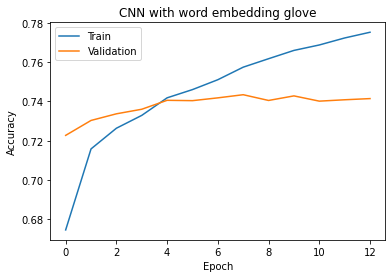

In [46]:
plt.plot(history_A.history['accuracy'])
plt.plot(history_A.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.title('CNN with word embedding glove')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

## Model B : RNN

In [47]:
inputs = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")

x = embedding_layer(inputs)
x = SpatialDropout1D(0.2)(x)

# Conv1D + LSTM (bidirectional)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)

# Vanilla hidden layer:
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_B = tf.keras.Model(inputs, outputs)

In [48]:
model_B.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           19842300  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 300)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 26, 64)            96064     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0   

In [49]:
model_B.compile(optimizer=Adam(), loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:
%%time
history_B = model_B.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_test, y_test), callbacks=[es, reduce_lr])

Epoch 1/30
157/157 [==============================] - 45s 261ms/step - loss: 0.5726 - accuracy: 0.6965 - val_loss: 0.5400 - val_accuracy: 0.7264
Epoch 2/30
157/157 [==============================] - 40s 254ms/step - loss: 0.5336 - accuracy: 0.7293 - val_loss: 0.5250 - val_accuracy: 0.7355
Epoch 3/30
157/157 [==============================] - 41s 262ms/step - loss: 0.5174 - accuracy: 0.7414 - val_loss: 0.5170 - val_accuracy: 0.7416
Epoch 4/30
157/157 [==============================] - 41s 262ms/step - loss: 0.5054 - accuracy: 0.7493 - val_loss: 0.5165 - val_accuracy: 0.7419
Epoch 5/30
157/157 [==============================] - 41s 263ms/step - loss: 0.4956 - accuracy: 0.7569 - val_loss: 0.5171 - val_accuracy: 0.7423
Epoch 6/30
157/157 [==============================] - 41s 259ms/step - loss: 0.4846 - accuracy: 0.7640 - val_loss: 0.5138 - val_accuracy: 0.7441
Epoch 7/30
157/157 [==============================] - 41s 262ms/step - loss: 0.4738 - accuracy: 0.7700 - val_loss: 0.5176 - val_ac

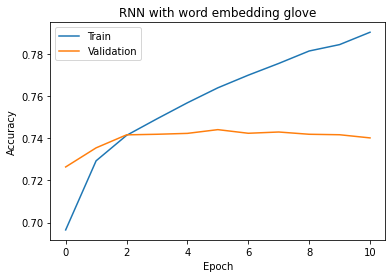

In [51]:
plt.plot(history_B.history['accuracy'])
plt.plot(history_B.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.title('RNN with word embedding glove')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')